# Baseline solution for Tiny ImageNet Challenge

You are presented with an opportunity to implement an Image Classifier for Tiny ImageNet dataset [same as used in CS231N](LINK). Tiny ImageNet contains 200 classes for training. Each class has 500 images. The test set contains 10,000 images. All images are 64x64 colored ones.

Your final goal is to demonstrate solid performance on the test split of the Tiny ImageNet dataset. We encourage you to show your thinking and demonstrate as many best practices along the way as you find appropriate.

We are looking for good analysis and presentation of the results, good problem decomposition and enough structure to allow for future foreseeable improvements. 

In [13]:
%%capture

from dataclasses import dataclass, replace
from pathlib import Path
from typing import Callable, List, Optional, Sequence, Union

import pandas as pd
import torch
import os
from pandas import DataFrame
from PIL import Image
from torch.utils.data.dataloader import default_collate
from torch.utils.data.dataset import Dataset
import sklearn
import numpy as np
from matplotlib import pyplot as plt

import numpy as np
from PIL import Image
from torchvision import transforms

from torchvision import models
from torch.nn.modules import loss
from torch import optim
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
from tqdm.auto import tqdm

# Getting the data

In [14]:
DATA_PATH = Path("/data")
DATA_PATH.mkdir(exist_ok=True)

In [15]:
!wget -q http://cs231n.stanford.edu/tiny-imagenet-200.zip -O $DATA_PATH/tiny-imagenet-200.zip

Unpacking our dataset will take a while, but it will only have to be done once.

Be prepared to wait next cell to finish up to 15 minutes

In [17]:
! unzip -q $DATA_PATH/tiny-imagenet-200.zip -d $DATA_PATH
! ls $DATA_PATH

tiny-imagenet-200  tiny-imagenet-200.zip


# Dataset

Here is a `TinyImagenetDataset` warpper you might find useful.

In [18]:
Transform = Callable[[Image.Image], Image.Image]


@dataclass()
class ItemsBatch:
    images: torch.Tensor
    labels: torch.Tensor
    ids: List[int]
    paths: List[Path]
    items: List["DatasetItem"]


@dataclass()
class DatasetItem:
    image: Union[torch.Tensor, Image.Image]
    label: int
    id: int
    path: Path

    @classmethod
    def collate(cls, items: Sequence["DatasetItem"]) -> ItemsBatch:
        if not isinstance(items, list):
            items = list(items)
        return ItemsBatch(
            images=default_collate([item.image for item in items]),
            labels=default_collate([item.label for item in items]),
            ids=[item.id for item in items],
            paths=[item.path for item in items],
            items=items,
        )

In [19]:
DATA_ROOT = DATA_PATH / "tiny-imagenet-200"
RESULTS_ROOT = Path("/project/results/")
CHECKPOINTS = RESULTS_ROOT / "checkpoints"
CHECKPOINTS.mkdir(parents=True, exist_ok=True)
TENSORBOARD_TAG = "fine_tune_resnet18"
CKPT_NAME = "first_model.pth"
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [20]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
DEVICE

device(type='cuda')

In [21]:
TRAIN_PATH = DATA_ROOT / "train"
VAL_PATH = DATA_ROOT / "val"
ALL_FOLDERS = [
    dir_name
    for r, d, f in os.walk(TRAIN_PATH)
    for dir_name in d
    if dir_name != "images"
]
FOLDERS_TO_NUM = {val: index for index, val in enumerate(ALL_FOLDERS)}

LABELS = pd.read_csv(
    DATA_ROOT / "words.txt", sep="\t", header=None, index_col=0)[1].to_dict()
VAL_LABELS = pd.read_csv(
    DATA_ROOT / "val" / "val_annotations.txt", sep="\t", header=None, index_col=0)[1].to_dict()

In [22]:
class TinyImagenetDataset(Dataset):
    _transform: Optional[Transform]
    _root: Path
    _df: DataFrame

    def __init__(self, path, transform: Optional[Transform] = None):
        self._transform = transform
        if not os.path.isdir(path):
            raise NotADirectoryError(f"{path} is not a directory.")
        all_files = [
            os.path.join(r, fyle)
            for r, d, f in os.walk(path)
            for fyle in f
            if ".JPEG" in fyle
        ]
        labels = [
            FOLDERS_TO_NUM.get(
                os.path.basename(f).split("_")[0],
                FOLDERS_TO_NUM.get(VAL_LABELS.get(os.path.basename(f))),
            )
            for f in all_files
        ]
        self._df = pd.DataFrame({"path": all_files, "label": labels})

    def __getitem__(self, index: int) -> DatasetItem:
        path, label = self._df.loc[index, :]
        image = Image.open(path).convert("RGB")
        if self._transform:
            image = self._transform(image)
        return DatasetItem(image=image, label=label, id=index, path=path)

    def __len__(self) -> int:
        return len(self._df)

# Training loop

This is a very basic training pipeline intended to rid you of writing too much boilerplate code

In [33]:
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.Resize(256),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    ]
)

train_dataset = TinyImagenetDataset(DATA_ROOT / "train", transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=DatasetItem.collate,
    num_workers=0,
    pin_memory=True
)

test_dataset = TinyImagenetDataset(DATA_ROOT / "val" / "images", transform)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=DatasetItem.collate,
    num_workers=0,
    pin_memory=True
)

In [25]:
def train(model, device, train_loader, optimizer, loss_function, epoch, writer):
    model.train()
    model.to(device)
    correct = 0
    for batch_idx, batch_data in enumerate(tqdm(train_loader)):
        data, target = batch_data.images.to(device), batch_data.labels.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    print(
        "Train Epoch: {} [ ({:.0f}%)]\tLoss: {:.6f}".format(
            epoch, 100.0 * correct / len(train_loader.dataset), loss.item()
        )
    )
    writer.add_scalar("train_loss_plot", loss.item(), global_step=epoch)
    writer.add_scalar(
        "train_accuracy_plot",
        100.0 * correct / len(train_loader.dataset),
        global_step=epoch,
    )


def test(model, device, test_loader, loss_function, epoch, writer):
    model.eval()
    model.to(device)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for idx, batch_data in enumerate(tqdm(test_loader)):
            data, target = batch_data.images.to(device), batch_data.labels.to(device)
            output = model(data)
            test_loss += loss_function(output, target).sum().item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )
    writer.add_scalar("test_loss_plot", test_loss, global_step=epoch)
    writer.add_scalar(
        "test_accuracy_plot",
        100.0 * correct / len(test_loader.dataset),
        global_step=epoch,
    )

## ResNet-18

In [26]:
from torch.optim.lr_scheduler import StepLR

In [112]:
TENSORBOARD_TAG = "resnet_18"

In [27]:
model = models.resnet18(pretrained=True)

for el in model.parameters():
    el.requires_grad=False
    
model.fc = nn.Linear(512, 200)
model = model.to(DEVICE)


optimizer = optim.SGD(model.fc.parameters(), lr=1e-2)

loss_function = loss.CrossEntropyLoss()

lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Please notice, that we added `break` in the training loop, your baseline basically is a `resnet18` without fine-tuning

Also we pre-set for you `tensorboard` output path, so it would be easier for us to follow your results

In [116]:
for epoch in range(50):
    writer = SummaryWriter(RESULTS_ROOT / TENSORBOARD_TAG)
#     break  # You should probably remove this in your training loop

    train(model, DEVICE, train_loader, optimizer, loss_function, epoch, writer)
    test(model, DEVICE, test_loader, loss_function, epoch, writer)
    lr_scheduler.step()
    writer.close()


Train Epoch: 0 [ (6%)]	Loss: 4.406989




Test set: Average loss: 0.0177, Accuracy: 1408/10000 (14%)




Train Epoch: 1 [ (19%)]	Loss: 3.911196




Test set: Average loss: 0.0154, Accuracy: 2305/10000 (23%)




Train Epoch: 2 [ (25%)]	Loss: 3.588570




Test set: Average loss: 0.0143, Accuracy: 2658/10000 (27%)




Train Epoch: 3 [ (29%)]	Loss: 3.518138




Test set: Average loss: 0.0136, Accuracy: 2838/10000 (28%)




Train Epoch: 4 [ (31%)]	Loss: 3.288159




Test set: Average loss: 0.0132, Accuracy: 3002/10000 (30%)




Train Epoch: 5 [ (32%)]	Loss: 3.190997




Test set: Average loss: 0.0129, Accuracy: 3081/10000 (31%)




Train Epoch: 6 [ (33%)]	Loss: 3.266251




Test set: Average loss: 0.0127, Accuracy: 3160/10000 (32%)




Train Epoch: 7 [ (34%)]	Loss: 3.097689




Test set: Average loss: 0.0125, Accuracy: 3229/10000 (32%)




Train Epoch: 8 [ (35%)]	Loss: 2.873488




Test set: Average loss: 0.0124, Accuracy: 3251/10000 (33%)




Train Epoch: 9 [ (35%)]	Loss: 2.931962




Test set: Average loss: 0.0122, Accuracy: 3304/10000 (33%)




Train Epoch: 10 [ (36%)]	Loss: 2.764575




Test set: Average loss: 0.0123, Accuracy: 3302/10000 (33%)




Train Epoch: 11 [ (36%)]	Loss: 2.958420




Test set: Average loss: 0.0121, Accuracy: 3317/10000 (33%)




Train Epoch: 12 [ (36%)]	Loss: 2.984621




Test set: Average loss: 0.0120, Accuracy: 3317/10000 (33%)




Train Epoch: 13 [ (36%)]	Loss: 3.112158




Test set: Average loss: 0.0121, Accuracy: 3349/10000 (33%)




Train Epoch: 14 [ (37%)]	Loss: 3.140762




Test set: Average loss: 0.0120, Accuracy: 3347/10000 (33%)




Train Epoch: 15 [ (37%)]	Loss: 2.804565




Test set: Average loss: 0.0120, Accuracy: 3370/10000 (34%)




Train Epoch: 16 [ (37%)]	Loss: 3.108149




Test set: Average loss: 0.0120, Accuracy: 3379/10000 (34%)




Train Epoch: 17 [ (37%)]	Loss: 2.717856




Test set: Average loss: 0.0120, Accuracy: 3401/10000 (34%)




Train Epoch: 18 [ (37%)]	Loss: 2.709415




Test set: Average loss: 0.0119, Accuracy: 3414/10000 (34%)




Train Epoch: 19 [ (38%)]	Loss: 2.864598




Test set: Average loss: 0.0119, Accuracy: 3407/10000 (34%)




Train Epoch: 20 [ (38%)]	Loss: 2.935891




Test set: Average loss: 0.0118, Accuracy: 3416/10000 (34%)




Train Epoch: 21 [ (38%)]	Loss: 2.831012




Test set: Average loss: 0.0119, Accuracy: 3420/10000 (34%)




Train Epoch: 22 [ (38%)]	Loss: 2.916749




Test set: Average loss: 0.0119, Accuracy: 3439/10000 (34%)




Train Epoch: 23 [ (38%)]	Loss: 2.800472




Test set: Average loss: 0.0118, Accuracy: 3431/10000 (34%)




Train Epoch: 24 [ (38%)]	Loss: 2.838557




Test set: Average loss: 0.0118, Accuracy: 3420/10000 (34%)




Train Epoch: 25 [ (38%)]	Loss: 2.759409




Test set: Average loss: 0.0118, Accuracy: 3432/10000 (34%)




Train Epoch: 26 [ (38%)]	Loss: 2.432848




Test set: Average loss: 0.0117, Accuracy: 3439/10000 (34%)




Train Epoch: 27 [ (38%)]	Loss: 2.713950




Test set: Average loss: 0.0117, Accuracy: 3449/10000 (34%)




Train Epoch: 28 [ (38%)]	Loss: 2.700251




Test set: Average loss: 0.0117, Accuracy: 3427/10000 (34%)




Train Epoch: 29 [ (38%)]	Loss: 2.729145




Test set: Average loss: 0.0118, Accuracy: 3471/10000 (35%)




Train Epoch: 30 [ (38%)]	Loss: 2.754088




Test set: Average loss: 0.0117, Accuracy: 3463/10000 (35%)




Train Epoch: 31 [ (39%)]	Loss: 2.406975




Test set: Average loss: 0.0117, Accuracy: 3488/10000 (35%)




Train Epoch: 32 [ (39%)]	Loss: 2.647754




Test set: Average loss: 0.0117, Accuracy: 3488/10000 (35%)




Train Epoch: 33 [ (39%)]	Loss: 2.535090




Test set: Average loss: 0.0117, Accuracy: 3450/10000 (34%)




Train Epoch: 34 [ (39%)]	Loss: 2.725212




Test set: Average loss: 0.0118, Accuracy: 3471/10000 (35%)




Train Epoch: 35 [ (39%)]	Loss: 2.815977




Test set: Average loss: 0.0118, Accuracy: 3465/10000 (35%)




Train Epoch: 36 [ (39%)]	Loss: 2.824888




Test set: Average loss: 0.0118, Accuracy: 3457/10000 (35%)




Train Epoch: 37 [ (39%)]	Loss: 2.685059




Test set: Average loss: 0.0117, Accuracy: 3462/10000 (35%)




Train Epoch: 38 [ (39%)]	Loss: 2.714920




Test set: Average loss: 0.0117, Accuracy: 3462/10000 (35%)




Train Epoch: 39 [ (39%)]	Loss: 2.495832




Test set: Average loss: 0.0117, Accuracy: 3478/10000 (35%)




Train Epoch: 40 [ (39%)]	Loss: 3.052650




Test set: Average loss: 0.0117, Accuracy: 3484/10000 (35%)




Train Epoch: 41 [ (39%)]	Loss: 2.622182




Test set: Average loss: 0.0117, Accuracy: 3494/10000 (35%)




Train Epoch: 42 [ (39%)]	Loss: 2.675014




Test set: Average loss: 0.0117, Accuracy: 3488/10000 (35%)




Train Epoch: 43 [ (39%)]	Loss: 2.573764




Test set: Average loss: 0.0117, Accuracy: 3491/10000 (35%)




Train Epoch: 44 [ (39%)]	Loss: 2.520800




Test set: Average loss: 0.0116, Accuracy: 3490/10000 (35%)




Train Epoch: 45 [ (39%)]	Loss: 2.575672




Test set: Average loss: 0.0117, Accuracy: 3494/10000 (35%)




Train Epoch: 46 [ (39%)]	Loss: 2.655358




Test set: Average loss: 0.0117, Accuracy: 3490/10000 (35%)




Train Epoch: 47 [ (39%)]	Loss: 2.886651




Test set: Average loss: 0.0117, Accuracy: 3503/10000 (35%)




Train Epoch: 48 [ (39%)]	Loss: 2.750626




Test set: Average loss: 0.0117, Accuracy: 3494/10000 (35%)




Train Epoch: 49 [ (39%)]	Loss: 2.588051




Test set: Average loss: 0.0117, Accuracy: 3516/10000 (35%)



In [117]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict()
           }, CHECKPOINTS / "fine_tuned_resnet.pth")

In [118]:
for el in model.parameters():
    el.requires_grad=True

optimizer = optim.SGD(model.parameters(), lr=1e-3)
lr_scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

In [119]:
for epoch in range(50, 100):
    writer = SummaryWriter(RESULTS_ROOT / TENSORBOARD_TAG)
#     break  # You should probably remove this in your training loop

    train(model, DEVICE, train_loader, optimizer, loss_function, epoch, writer)
    test(model, DEVICE, test_loader, loss_function, epoch, writer)
    lr_scheduler.step()
    writer.close()


Train Epoch: 50 [ (42%)]	Loss: 2.495327




Test set: Average loss: 0.0105, Accuracy: 3940/10000 (39%)




Train Epoch: 51 [ (45%)]	Loss: 2.394349




Test set: Average loss: 0.0100, Accuracy: 4123/10000 (41%)




Train Epoch: 52 [ (47%)]	Loss: 2.004857




Test set: Average loss: 0.0097, Accuracy: 4247/10000 (42%)




Train Epoch: 53 [ (48%)]	Loss: 2.413080




Test set: Average loss: 0.0094, Accuracy: 4368/10000 (44%)




Train Epoch: 54 [ (49%)]	Loss: 2.207040




Test set: Average loss: 0.0092, Accuracy: 4442/10000 (44%)




Train Epoch: 55 [ (51%)]	Loss: 1.881882




Test set: Average loss: 0.0092, Accuracy: 4508/10000 (45%)




Train Epoch: 56 [ (51%)]	Loss: 2.074325




Test set: Average loss: 0.0091, Accuracy: 4578/10000 (46%)




Train Epoch: 57 [ (53%)]	Loss: 1.957847




Test set: Average loss: 0.0089, Accuracy: 4597/10000 (46%)




Train Epoch: 58 [ (53%)]	Loss: 1.866282




Test set: Average loss: 0.0088, Accuracy: 4674/10000 (47%)




Train Epoch: 59 [ (54%)]	Loss: 1.955038




Test set: Average loss: 0.0088, Accuracy: 4711/10000 (47%)




Train Epoch: 60 [ (55%)]	Loss: 1.848189




Test set: Average loss: 0.0088, Accuracy: 4765/10000 (48%)




Train Epoch: 61 [ (56%)]	Loss: 1.668361




Test set: Average loss: 0.0087, Accuracy: 4777/10000 (48%)




Train Epoch: 62 [ (56%)]	Loss: 1.634086




Test set: Average loss: 0.0086, Accuracy: 4790/10000 (48%)




Train Epoch: 63 [ (57%)]	Loss: 1.583678




Test set: Average loss: 0.0085, Accuracy: 4842/10000 (48%)




Train Epoch: 64 [ (58%)]	Loss: 1.702281




Test set: Average loss: 0.0085, Accuracy: 4826/10000 (48%)




Train Epoch: 65 [ (58%)]	Loss: 1.486606




Test set: Average loss: 0.0085, Accuracy: 4874/10000 (49%)




Train Epoch: 66 [ (59%)]	Loss: 1.635699




Test set: Average loss: 0.0084, Accuracy: 4876/10000 (49%)




Train Epoch: 67 [ (60%)]	Loss: 1.389088




Test set: Average loss: 0.0084, Accuracy: 4898/10000 (49%)




Train Epoch: 68 [ (60%)]	Loss: 1.524655




Test set: Average loss: 0.0083, Accuracy: 4946/10000 (49%)




Train Epoch: 69 [ (61%)]	Loss: 1.478074




Test set: Average loss: 0.0083, Accuracy: 4957/10000 (50%)




Train Epoch: 70 [ (61%)]	Loss: 1.704152




Test set: Average loss: 0.0083, Accuracy: 4950/10000 (50%)




Train Epoch: 71 [ (62%)]	Loss: 1.756676




Test set: Average loss: 0.0083, Accuracy: 4974/10000 (50%)




Train Epoch: 72 [ (62%)]	Loss: 1.669059




Test set: Average loss: 0.0082, Accuracy: 4978/10000 (50%)




Train Epoch: 73 [ (62%)]	Loss: 1.566625




Test set: Average loss: 0.0083, Accuracy: 5004/10000 (50%)




Train Epoch: 74 [ (62%)]	Loss: 1.675928




Test set: Average loss: 0.0083, Accuracy: 4968/10000 (50%)




Train Epoch: 75 [ (63%)]	Loss: 1.582408




Test set: Average loss: 0.0082, Accuracy: 4989/10000 (50%)




Train Epoch: 76 [ (63%)]	Loss: 1.482758




Test set: Average loss: 0.0082, Accuracy: 5005/10000 (50%)




Train Epoch: 77 [ (63%)]	Loss: 1.496782




Test set: Average loss: 0.0081, Accuracy: 5022/10000 (50%)




Train Epoch: 78 [ (64%)]	Loss: 1.387870




Test set: Average loss: 0.0082, Accuracy: 5020/10000 (50%)




Train Epoch: 79 [ (64%)]	Loss: 1.386854




Test set: Average loss: 0.0081, Accuracy: 5028/10000 (50%)




Train Epoch: 80 [ (64%)]	Loss: 1.695139




Test set: Average loss: 0.0081, Accuracy: 5032/10000 (50%)




Train Epoch: 81 [ (64%)]	Loss: 1.537895




Test set: Average loss: 0.0081, Accuracy: 5052/10000 (51%)




Train Epoch: 82 [ (65%)]	Loss: 1.321518




Test set: Average loss: 0.0080, Accuracy: 5032/10000 (50%)




Train Epoch: 83 [ (65%)]	Loss: 1.600445




Test set: Average loss: 0.0081, Accuracy: 5052/10000 (51%)




Train Epoch: 84 [ (65%)]	Loss: 1.536119




Test set: Average loss: 0.0082, Accuracy: 5052/10000 (51%)




Train Epoch: 85 [ (65%)]	Loss: 1.543137




Test set: Average loss: 0.0082, Accuracy: 5043/10000 (50%)




Train Epoch: 86 [ (66%)]	Loss: 1.206012




Test set: Average loss: 0.0081, Accuracy: 5060/10000 (51%)




Train Epoch: 87 [ (66%)]	Loss: 1.606008




Test set: Average loss: 0.0081, Accuracy: 5057/10000 (51%)




Train Epoch: 88 [ (66%)]	Loss: 1.485514




Test set: Average loss: 0.0081, Accuracy: 5065/10000 (51%)




Train Epoch: 89 [ (66%)]	Loss: 1.370366




Test set: Average loss: 0.0081, Accuracy: 5060/10000 (51%)




Train Epoch: 90 [ (67%)]	Loss: 1.351304




Test set: Average loss: 0.0081, Accuracy: 5086/10000 (51%)




Train Epoch: 91 [ (67%)]	Loss: 1.125075




Test set: Average loss: 0.0081, Accuracy: 5087/10000 (51%)




Train Epoch: 92 [ (67%)]	Loss: 1.313108




Test set: Average loss: 0.0081, Accuracy: 5080/10000 (51%)




Train Epoch: 93 [ (67%)]	Loss: 1.298735




Test set: Average loss: 0.0080, Accuracy: 5093/10000 (51%)




Train Epoch: 94 [ (67%)]	Loss: 1.314118




Test set: Average loss: 0.0081, Accuracy: 5083/10000 (51%)




Train Epoch: 95 [ (67%)]	Loss: 1.252575




Test set: Average loss: 0.0081, Accuracy: 5078/10000 (51%)




Train Epoch: 96 [ (67%)]	Loss: 1.284905




Test set: Average loss: 0.0081, Accuracy: 5098/10000 (51%)




Train Epoch: 97 [ (67%)]	Loss: 1.431200




Test set: Average loss: 0.0081, Accuracy: 5090/10000 (51%)




Train Epoch: 98 [ (68%)]	Loss: 1.369294




Test set: Average loss: 0.0081, Accuracy: 5093/10000 (51%)




Train Epoch: 99 [ (68%)]	Loss: 1.464185




Test set: Average loss: 0.0081, Accuracy: 5102/10000 (51%)



In [120]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict()
           }, CHECKPOINTS / "full_resnet.pth")


## Efficientnet b3

In [28]:
TENSORBOARD_TAG = "efficientnet_b3_high_res"

In [29]:
! pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=f5c34ba8577ec741d1b235b128d716a2423b4dd5993bd55d258a7a5dd341b34b
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [30]:
from efficientnet_pytorch import EfficientNet

In [34]:
model = EfficientNet.from_pretrained("efficientnet-b3", num_classes=200)


# for el in list(model.parameters())[:-1]:    
#     el.requires_grad=False
    
# model.fc = nn.Linear(512, 200)
model = model.to(DEVICE)

# for el in model.parameters():
#     el.requires_grad=False
    
# for el in model.fc.parameters():
#     el.requires_grad=True


lr = 1e-2
optimizer = optim.SGD([
    {
        "params": list(model.parameters())[:-6],
        "lr": lr*0.1
    },
    {
        "params": list(model.parameters())[-6:],
        "lr": lr
    }
    
])
lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
loss_function = loss.CrossEntropyLoss()

Loaded pretrained weights for efficientnet-b3


In [35]:
for epoch in range(100):
    writer = SummaryWriter(RESULTS_ROOT / TENSORBOARD_TAG)
#     break  # You should probably remove this in your training loop

    train(model, DEVICE, train_loader, optimizer, loss_function, epoch, writer)
    test(model, DEVICE, test_loader, loss_function, epoch, writer)
    lr_scheduler.step()
    writer.close()


Train Epoch: 0 [ (41%)]	Loss: 2.486635




Test set: Average loss: 0.0763, Accuracy: 6978/10000 (70%)




Train Epoch: 1 [ (69%)]	Loss: 0.928994




Test set: Average loss: 0.0319, Accuracy: 7845/10000 (78%)




Train Epoch: 2 [ (74%)]	Loss: 1.015429




Test set: Average loss: 0.0245, Accuracy: 8098/10000 (81%)




Train Epoch: 3 [ (76%)]	Loss: 0.806931




Test set: Average loss: 0.0217, Accuracy: 8278/10000 (83%)




Train Epoch: 4 [ (78%)]	Loss: 0.635213




Test set: Average loss: 0.0200, Accuracy: 8339/10000 (83%)




Train Epoch: 5 [ (79%)]	Loss: 0.702231




Test set: Average loss: 0.0190, Accuracy: 8398/10000 (84%)




Train Epoch: 6 [ (80%)]	Loss: 0.426520




Test set: Average loss: 0.0184, Accuracy: 8436/10000 (84%)




Train Epoch: 7 [ (81%)]	Loss: 0.861159




Test set: Average loss: 0.0179, Accuracy: 8479/10000 (85%)




Train Epoch: 8 [ (82%)]	Loss: 0.996336




Test set: Average loss: 0.0173, Accuracy: 8527/10000 (85%)




Train Epoch: 9 [ (83%)]	Loss: 0.816888




Test set: Average loss: 0.0170, Accuracy: 8516/10000 (85%)




Train Epoch: 10 [ (84%)]	Loss: 0.705529




Test set: Average loss: 0.0167, Accuracy: 8562/10000 (86%)




Train Epoch: 11 [ (84%)]	Loss: 0.443053




Test set: Average loss: 0.0168, Accuracy: 8557/10000 (86%)




Train Epoch: 12 [ (84%)]	Loss: 0.586852




Test set: Average loss: 0.0165, Accuracy: 8564/10000 (86%)




Train Epoch: 13 [ (85%)]	Loss: 0.274183




Test set: Average loss: 0.0163, Accuracy: 8597/10000 (86%)




Train Epoch: 14 [ (85%)]	Loss: 0.787037




Test set: Average loss: 0.0163, Accuracy: 8576/10000 (86%)




Train Epoch: 15 [ (85%)]	Loss: 0.592279




Test set: Average loss: 0.0161, Accuracy: 8603/10000 (86%)




Train Epoch: 16 [ (85%)]	Loss: 0.897568




Test set: Average loss: 0.0162, Accuracy: 8598/10000 (86%)




Train Epoch: 17 [ (86%)]	Loss: 0.424003




Test set: Average loss: 0.0161, Accuracy: 8621/10000 (86%)




Train Epoch: 18 [ (85%)]	Loss: 0.290425




Test set: Average loss: 0.0162, Accuracy: 8595/10000 (86%)




Train Epoch: 19 [ (86%)]	Loss: 0.948646




Test set: Average loss: 0.0159, Accuracy: 8619/10000 (86%)




Train Epoch: 20 [ (86%)]	Loss: 0.431739




Test set: Average loss: 0.0160, Accuracy: 8622/10000 (86%)




Train Epoch: 21 [ (86%)]	Loss: 0.808725




Test set: Average loss: 0.0160, Accuracy: 8616/10000 (86%)




Train Epoch: 22 [ (86%)]	Loss: 0.305037




Test set: Average loss: 0.0160, Accuracy: 8629/10000 (86%)




Train Epoch: 23 [ (86%)]	Loss: 0.548276




Test set: Average loss: 0.0159, Accuracy: 8624/10000 (86%)




Train Epoch: 24 [ (86%)]	Loss: 0.445119




Test set: Average loss: 0.0159, Accuracy: 8637/10000 (86%)




Train Epoch: 25 [ (87%)]	Loss: 0.692848




Test set: Average loss: 0.0158, Accuracy: 8633/10000 (86%)




Train Epoch: 26 [ (87%)]	Loss: 0.582334




Test set: Average loss: 0.0158, Accuracy: 8644/10000 (86%)




Train Epoch: 27 [ (87%)]	Loss: 0.449130




Test set: Average loss: 0.0158, Accuracy: 8610/10000 (86%)




Train Epoch: 28 [ (87%)]	Loss: 0.410164




Test set: Average loss: 0.0159, Accuracy: 8612/10000 (86%)




Train Epoch: 29 [ (87%)]	Loss: 0.269458




Test set: Average loss: 0.0156, Accuracy: 8646/10000 (86%)




Train Epoch: 30 [ (87%)]	Loss: 0.530468




Test set: Average loss: 0.0158, Accuracy: 8633/10000 (86%)




Train Epoch: 31 [ (87%)]	Loss: 0.398181




Test set: Average loss: 0.0158, Accuracy: 8621/10000 (86%)




Train Epoch: 32 [ (87%)]	Loss: 0.148088




Test set: Average loss: 0.0156, Accuracy: 8650/10000 (86%)




Train Epoch: 33 [ (87%)]	Loss: 0.446108




Test set: Average loss: 0.0156, Accuracy: 8651/10000 (87%)




Train Epoch: 34 [ (87%)]	Loss: 0.255604




Test set: Average loss: 0.0158, Accuracy: 8622/10000 (86%)




Train Epoch: 35 [ (87%)]	Loss: 0.361755




Test set: Average loss: 0.0158, Accuracy: 8631/10000 (86%)




Train Epoch: 36 [ (87%)]	Loss: 0.566815




Test set: Average loss: 0.0156, Accuracy: 8651/10000 (87%)




Train Epoch: 37 [ (87%)]	Loss: 0.435389




Test set: Average loss: 0.0157, Accuracy: 8635/10000 (86%)




Train Epoch: 38 [ (87%)]	Loss: 0.565584




Test set: Average loss: 0.0157, Accuracy: 8654/10000 (87%)




Train Epoch: 39 [ (87%)]	Loss: 0.427484




Test set: Average loss: 0.0157, Accuracy: 8647/10000 (86%)




Train Epoch: 40 [ (88%)]	Loss: 0.256302




Test set: Average loss: 0.0157, Accuracy: 8649/10000 (86%)




Train Epoch: 41 [ (88%)]	Loss: 0.265870




Test set: Average loss: 0.0156, Accuracy: 8660/10000 (87%)




Train Epoch: 42 [ (88%)]	Loss: 0.470698




Test set: Average loss: 0.0155, Accuracy: 8658/10000 (87%)




Train Epoch: 43 [ (88%)]	Loss: 0.611763




Test set: Average loss: 0.0155, Accuracy: 8664/10000 (87%)




Train Epoch: 44 [ (88%)]	Loss: 0.459587




Test set: Average loss: 0.0156, Accuracy: 8641/10000 (86%)




Train Epoch: 45 [ (88%)]	Loss: 0.563292




Test set: Average loss: 0.0156, Accuracy: 8622/10000 (86%)




Train Epoch: 46 [ (88%)]	Loss: 0.568090




Test set: Average loss: 0.0155, Accuracy: 8618/10000 (86%)




Train Epoch: 47 [ (88%)]	Loss: 0.424849




Test set: Average loss: 0.0156, Accuracy: 8652/10000 (87%)




Train Epoch: 48 [ (88%)]	Loss: 0.201000




Test set: Average loss: 0.0156, Accuracy: 8634/10000 (86%)




Train Epoch: 49 [ (88%)]	Loss: 0.495716




Test set: Average loss: 0.0156, Accuracy: 8644/10000 (86%)




Train Epoch: 50 [ (88%)]	Loss: 0.686611




Test set: Average loss: 0.0156, Accuracy: 8627/10000 (86%)




Train Epoch: 51 [ (88%)]	Loss: 0.479134




Test set: Average loss: 0.0155, Accuracy: 8649/10000 (86%)




Train Epoch: 52 [ (88%)]	Loss: 0.515239




Test set: Average loss: 0.0157, Accuracy: 8635/10000 (86%)




Train Epoch: 53 [ (88%)]	Loss: 0.372110




Test set: Average loss: 0.0154, Accuracy: 8644/10000 (86%)




Train Epoch: 54 [ (88%)]	Loss: 0.657246




Test set: Average loss: 0.0156, Accuracy: 8639/10000 (86%)




Train Epoch: 55 [ (88%)]	Loss: 0.336565




Test set: Average loss: 0.0155, Accuracy: 8648/10000 (86%)




Train Epoch: 56 [ (88%)]	Loss: 0.726044




Test set: Average loss: 0.0156, Accuracy: 8633/10000 (86%)




Train Epoch: 57 [ (88%)]	Loss: 0.518117




Test set: Average loss: 0.0157, Accuracy: 8622/10000 (86%)




Train Epoch: 58 [ (88%)]	Loss: 0.756565




Test set: Average loss: 0.0155, Accuracy: 8640/10000 (86%)




Train Epoch: 59 [ (88%)]	Loss: 0.268833




Test set: Average loss: 0.0156, Accuracy: 8647/10000 (86%)




Train Epoch: 60 [ (88%)]	Loss: 0.419633




Test set: Average loss: 0.0156, Accuracy: 8656/10000 (87%)




Train Epoch: 61 [ (88%)]	Loss: 0.320830




Test set: Average loss: 0.0156, Accuracy: 8632/10000 (86%)




Train Epoch: 62 [ (88%)]	Loss: 0.608140




Test set: Average loss: 0.0155, Accuracy: 8652/10000 (87%)




Train Epoch: 63 [ (88%)]	Loss: 0.478901




Test set: Average loss: 0.0156, Accuracy: 8655/10000 (87%)




Train Epoch: 64 [ (88%)]	Loss: 0.759067




Test set: Average loss: 0.0155, Accuracy: 8649/10000 (86%)




Train Epoch: 65 [ (88%)]	Loss: 0.357403




Test set: Average loss: 0.0156, Accuracy: 8623/10000 (86%)




Train Epoch: 66 [ (88%)]	Loss: 0.516094




Test set: Average loss: 0.0156, Accuracy: 8641/10000 (86%)




Train Epoch: 67 [ (88%)]	Loss: 0.629170




Test set: Average loss: 0.0156, Accuracy: 8645/10000 (86%)




Train Epoch: 68 [ (88%)]	Loss: 0.471711




Test set: Average loss: 0.0155, Accuracy: 8644/10000 (86%)




Train Epoch: 69 [ (88%)]	Loss: 0.333140




Test set: Average loss: 0.0154, Accuracy: 8678/10000 (87%)




Train Epoch: 70 [ (88%)]	Loss: 0.455427




Test set: Average loss: 0.0156, Accuracy: 8653/10000 (87%)




Train Epoch: 71 [ (88%)]	Loss: 0.464161




Test set: Average loss: 0.0155, Accuracy: 8651/10000 (87%)




Train Epoch: 72 [ (88%)]	Loss: 0.406184




Test set: Average loss: 0.0155, Accuracy: 8633/10000 (86%)




Train Epoch: 73 [ (88%)]	Loss: 0.353487




Test set: Average loss: 0.0158, Accuracy: 8639/10000 (86%)




Train Epoch: 74 [ (88%)]	Loss: 0.524487




Test set: Average loss: 0.0155, Accuracy: 8661/10000 (87%)




Train Epoch: 75 [ (88%)]	Loss: 0.567120




Test set: Average loss: 0.0155, Accuracy: 8665/10000 (87%)




Train Epoch: 76 [ (88%)]	Loss: 0.527734




Test set: Average loss: 0.0154, Accuracy: 8657/10000 (87%)




Train Epoch: 77 [ (88%)]	Loss: 0.603305




Test set: Average loss: 0.0156, Accuracy: 8647/10000 (86%)




Train Epoch: 78 [ (88%)]	Loss: 0.155852




Test set: Average loss: 0.0154, Accuracy: 8650/10000 (86%)




Train Epoch: 79 [ (88%)]	Loss: 0.340889




Test set: Average loss: 0.0156, Accuracy: 8658/10000 (87%)




Train Epoch: 80 [ (88%)]	Loss: 0.440375




Test set: Average loss: 0.0155, Accuracy: 8671/10000 (87%)




Train Epoch: 81 [ (88%)]	Loss: 0.586613




Test set: Average loss: 0.0156, Accuracy: 8645/10000 (86%)




Train Epoch: 82 [ (88%)]	Loss: 0.541904




Test set: Average loss: 0.0154, Accuracy: 8656/10000 (87%)




Train Epoch: 83 [ (88%)]	Loss: 0.286895




Test set: Average loss: 0.0155, Accuracy: 8641/10000 (86%)




Train Epoch: 84 [ (88%)]	Loss: 0.349834




Test set: Average loss: 0.0156, Accuracy: 8642/10000 (86%)




Train Epoch: 85 [ (88%)]	Loss: 0.660012




Test set: Average loss: 0.0157, Accuracy: 8659/10000 (87%)




Train Epoch: 86 [ (88%)]	Loss: 0.402802




Test set: Average loss: 0.0155, Accuracy: 8664/10000 (87%)




Train Epoch: 87 [ (88%)]	Loss: 0.815546




Test set: Average loss: 0.0156, Accuracy: 8655/10000 (87%)




Train Epoch: 88 [ (88%)]	Loss: 0.470069




Test set: Average loss: 0.0156, Accuracy: 8645/10000 (86%)




Train Epoch: 89 [ (88%)]	Loss: 0.352320




Test set: Average loss: 0.0156, Accuracy: 8626/10000 (86%)




Train Epoch: 90 [ (88%)]	Loss: 0.443143




Test set: Average loss: 0.0155, Accuracy: 8648/10000 (86%)




Train Epoch: 91 [ (88%)]	Loss: 0.705067




Test set: Average loss: 0.0155, Accuracy: 8677/10000 (87%)




Train Epoch: 92 [ (88%)]	Loss: 0.319297




Test set: Average loss: 0.0155, Accuracy: 8645/10000 (86%)




Train Epoch: 93 [ (88%)]	Loss: 0.393877




Test set: Average loss: 0.0157, Accuracy: 8652/10000 (87%)




Train Epoch: 94 [ (88%)]	Loss: 0.253319




Test set: Average loss: 0.0154, Accuracy: 8659/10000 (87%)




Train Epoch: 95 [ (88%)]	Loss: 0.396037




Test set: Average loss: 0.0155, Accuracy: 8642/10000 (86%)




Train Epoch: 96 [ (88%)]	Loss: 0.418623




Test set: Average loss: 0.0157, Accuracy: 8643/10000 (86%)




Train Epoch: 97 [ (88%)]	Loss: 0.351755




Test set: Average loss: 0.0155, Accuracy: 8654/10000 (87%)



KeyboardInterrupt: 

In [36]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict()
           }, CHECKPOINTS / "efficientnet_b3_high_res.pth")


In [132]:
optimizer = optim.SGD(model.parameters(), lr=1e-3)
for epoch in range(100, 200):
    writer = SummaryWriter(RESULTS_ROOT / TENSORBOARD_TAG)
#     break  # You should probably remove this in your training loop

    train(model, DEVICE, train_loader, optimizer, loss_function, epoch, writer)
    test(model, DEVICE, test_loader, loss_function, epoch, writer)
    writer.close()


Train Epoch: 100 [ (96%)]	Loss: 0.112400




Test set: Average loss: 0.0079, Accuracy: 6218/10000 (62%)




Train Epoch: 101 [ (96%)]	Loss: 0.200043




Test set: Average loss: 0.0081, Accuracy: 6218/10000 (62%)




Train Epoch: 102 [ (96%)]	Loss: 0.176464




Test set: Average loss: 0.0080, Accuracy: 6215/10000 (62%)




Train Epoch: 103 [ (96%)]	Loss: 0.109749




Test set: Average loss: 0.0079, Accuracy: 6208/10000 (62%)




Train Epoch: 104 [ (96%)]	Loss: 0.135477




Test set: Average loss: 0.0079, Accuracy: 6207/10000 (62%)




Train Epoch: 105 [ (96%)]	Loss: 0.159083




Test set: Average loss: 0.0080, Accuracy: 6215/10000 (62%)




Train Epoch: 106 [ (96%)]	Loss: 0.170151




Test set: Average loss: 0.0079, Accuracy: 6213/10000 (62%)




Train Epoch: 107 [ (96%)]	Loss: 0.224244




Test set: Average loss: 0.0080, Accuracy: 6215/10000 (62%)




Train Epoch: 108 [ (96%)]	Loss: 0.120015




Test set: Average loss: 0.0079, Accuracy: 6214/10000 (62%)




Train Epoch: 109 [ (96%)]	Loss: 0.145250




Test set: Average loss: 0.0080, Accuracy: 6215/10000 (62%)




Train Epoch: 110 [ (96%)]	Loss: 0.180170




Test set: Average loss: 0.0080, Accuracy: 6217/10000 (62%)




Train Epoch: 111 [ (96%)]	Loss: 0.178251




Test set: Average loss: 0.0080, Accuracy: 6221/10000 (62%)




Train Epoch: 112 [ (97%)]	Loss: 0.114182




Test set: Average loss: 0.0080, Accuracy: 6221/10000 (62%)




Train Epoch: 113 [ (96%)]	Loss: 0.157429




Test set: Average loss: 0.0081, Accuracy: 6208/10000 (62%)




Train Epoch: 114 [ (96%)]	Loss: 0.162826




Test set: Average loss: 0.0082, Accuracy: 6220/10000 (62%)



KeyboardInterrupt: 

# Loading model

In [111]:
MODEL_PATH = CHECKPOINTS / "efficientnet_b3_high_res.pth"

In [112]:
model_dict = torch.load(MODEL_PATH)
model.load_state_dict(model_dict["model_state_dict"])

<All keys matched successfully>

# Visualisation

Here is also a confusion matrix plot for you

In [113]:
import sklearn
import numpy as np
from matplotlib import pyplot as plt

In [114]:
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([200, 200], int)

with torch.no_grad():
    for item in tqdm(test_loader):
        images, labels = item.images.to(DEVICE), item.labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1

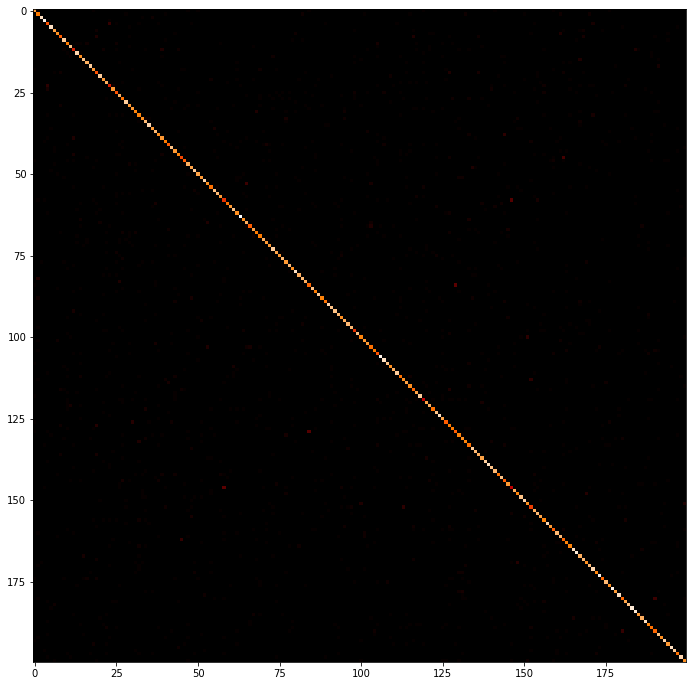

In [115]:
plt.figure(figsize=(12, 12))
plt.imshow(confusion_matrix, cmap="gist_heat", interpolation="nearest")
# plt.savefig("/data/conf_matrix.png")
plt.show()

In [116]:
av = []
for i in range(200):
    av.append(confusion_matrix[i][i]/50)

In [117]:
print("AP: ", np.mean(av))

AP:  0.8102000000000001


In [42]:
confusion_matrix

array([[43,  0,  0, ...,  0,  0,  0],
       [ 0, 37,  0, ...,  0,  0,  0],
       [ 0,  0, 47, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 37,  0,  0],
       [ 0,  0,  0, ...,  0, 45,  0],
       [ 0,  0,  0, ...,  0,  0, 38]])

In [61]:
efficientnet_b3 = pd.read_csv("run-efficientnet_b3-tag-test_accuracy_plot.csv")
efficientnet_b3_high_res = pd.read_csv("run-efficientnet_b3_high_res-tag-test_accuracy_plot.csv")
resnet = pd.read_csv("run-fine_tune-tag-test_accuracy_plot.csv")

In [106]:
results_paths = {
    "efficientnet-b3" : "run-efficientnet_b3-tag-test_accuracy_plot.csv",
    "efficientnet-b3 high res fine tuned" : "run-efficientnet_b3_high_res-tag-test_accuracy_plot.csv", 
    "resnet-18" : "run-fine_tune-tag-test_accuracy_plot.csv"
}

In [64]:
efficientnet_b3.columns

Index(['Wall time', 'Step', 'Value'], dtype='object')

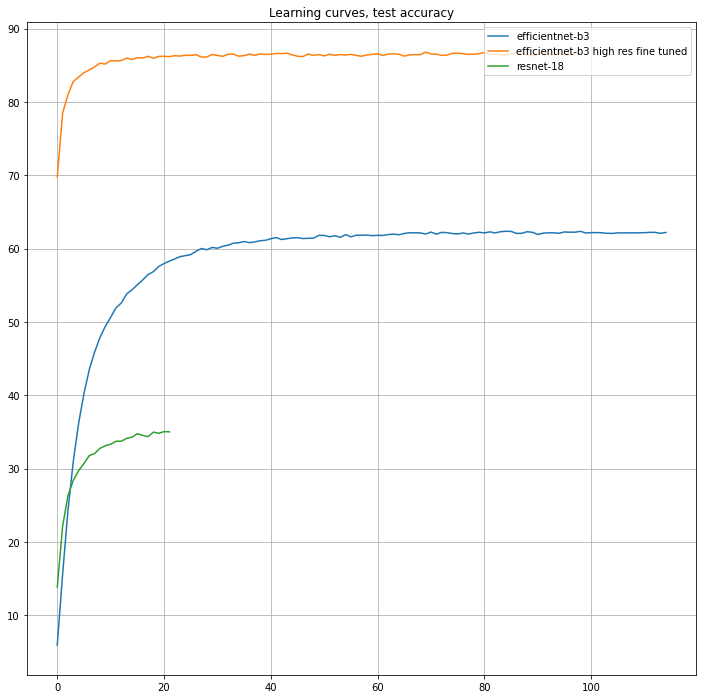

<Figure size 432x288 with 0 Axes>

In [107]:
plt.figure(figsize=(12, 12))
plt.title("Learning curves, test accuracy")
plt.grid()
for path in results_paths.values():
    data = pd.read_csv(path)
    plt.plot(data["Step"].values, data["Value"].values)    
plt.legend(results_paths.keys(), loc = "upper right")
plt.show()
plt.savefig("graphs.png")
